## HMM EXAMPLES  with Continuous Densities



In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [18]:
%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd

from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm
from pyspch.core import make_seq1
from pyspch import display as Spd

pd.set_option('display.float_format','{:,.3f}'.format)
pd.set_option('display.precision',3)
# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
cmap_car = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap="OrRd_r"
pd.options.display.float_format = '{:,.3f}'.format
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

# catch future warnings -- occurring in matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

### Import Sequence Data
make_seq1() imports two sets of labeled sequence data.
We will typically use X1,y1 for training and X2,y2 for testing; but you can turn this around if you want to.

There are 3 classes and 4 features.   
Each data set containing 75 data points and classes come in sequence.  
We create a few test scenarios:
 - X3 is a noisy version of X2
 - X4 is a very noisy version of X2
 - X2s is a shorter version of X2
 - X3s is a similar shortened version of X3


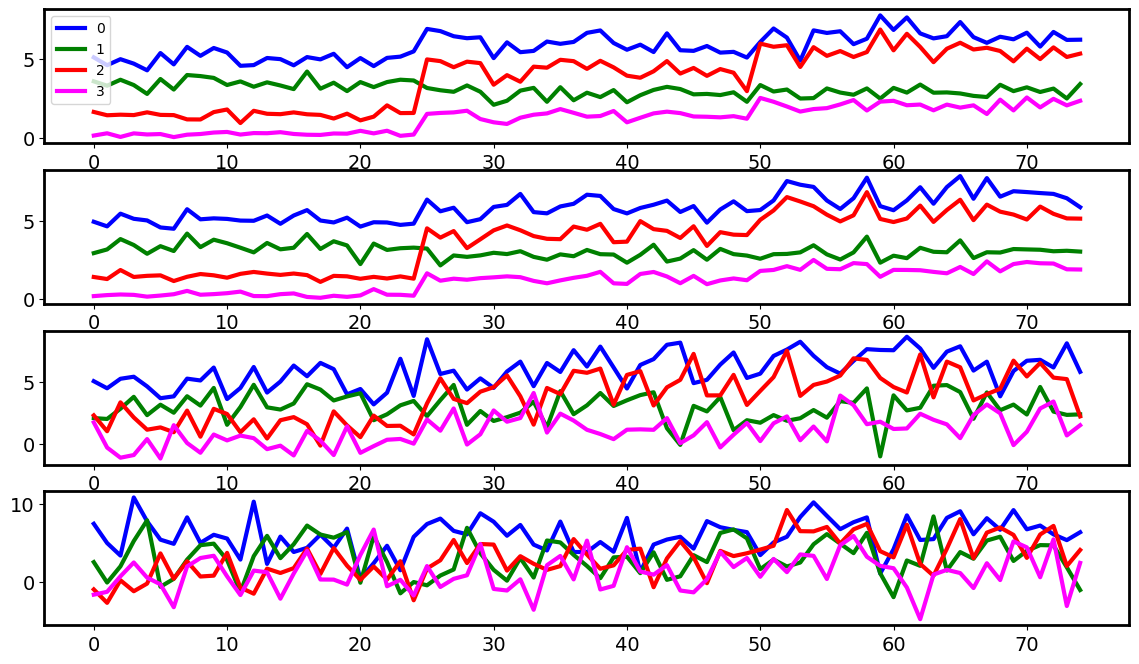

In [20]:
(X1,y1) = make_seq1(subset=1)
(X2,y2) = make_seq1(subset=2)
X3 = X2 + np.random.normal(scale=1., size=X2.shape)
X4 = X2 + np.random.normal(scale=2., size=X2.shape)
X1s = X1[0::5,:]
X2s = X2[0::5,:]
X3s = X3[0::5,:]
X4s = X4[0::5,:]
y1s = y1[0::5]
y2s = y2[0::5]
#
f,ax=plt.subplots(4,figsize=(14,8))
ax[0].plot(X1)
ax[1].plot(X2)
ax[2].plot(X3)
ax[3].plot(X4)
ax[0].legend(np.arange(4));

### Single Frame Classification

In a first analysis we make abstraction of the sequence nature of the data and focus on what information is available in each frame by itself.

From a quick observation of the data we estimate means for the different classes and assign equal variance in our  very rough model.   
We evaluate for frame classification.  It's far from perfect, but not horrible either.

,prior,mean,var
0,0.333,"[5.5, 3.5, 4.0, 1.4]","[0.1, 0.1, 0.1, 0.1]"
1,0.333,"[6.0, 2.5, 4.4, 1.5]","[0.1, 0.1, 0.1, 0.1]"
2,0.333,"[6.5, 3.0, 4.5, 2.0]","[0.1, 0.1, 0.1, 0.1]"


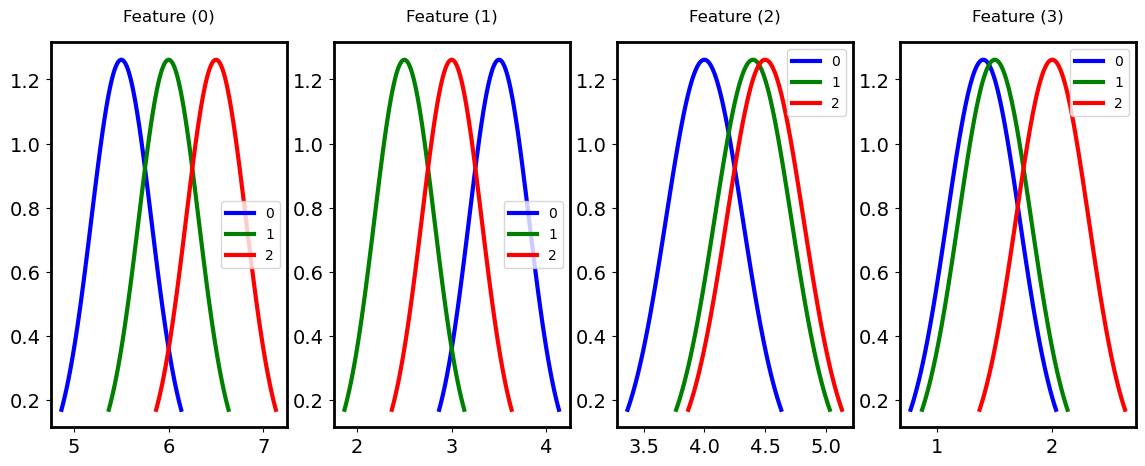

In [21]:
Gauss1 = Densities.Gaussian()
mu = np.array([
    [5.5, 3.5, 4.,1.4],
    [6., 2.5, 4.4, 1.5  ],
    [6.5, 3.0, 4.5, 2.]
])
var = .1*np.ones(mu.shape)
Gauss1.init_model(mu=mu,var=var)
Gauss1.print_model()
Gauss1.plot_model()

### Likelihoods and Posteriors

The Gaussian Densities compute the likelihood that a feature vector is drawn from a given distribution.  After application of Bayes formula these likelihoods may be converted to posteriors, i.e. the probability that the feature vector was drawn from a particular class.

If priors are uniform amongst all classes, then the posterior computation is nothing more than a normalization such that the sum of all values are 1.0.  It emphasizes that the absolute values of the likelihoods are often meaningless, but it is there relative values that are decisive.
In the plot below you may see that the likelihoods for class '0' are very low for in class data (the model is not so good) , but nevertheless thy are still very distinctive from the other classes and recognition of class '0' data is probably perfect.

In the plots below, you observe frame likelihoods 2 times (line plot and heatmap plot) and in the bottom axis the posteriors. 

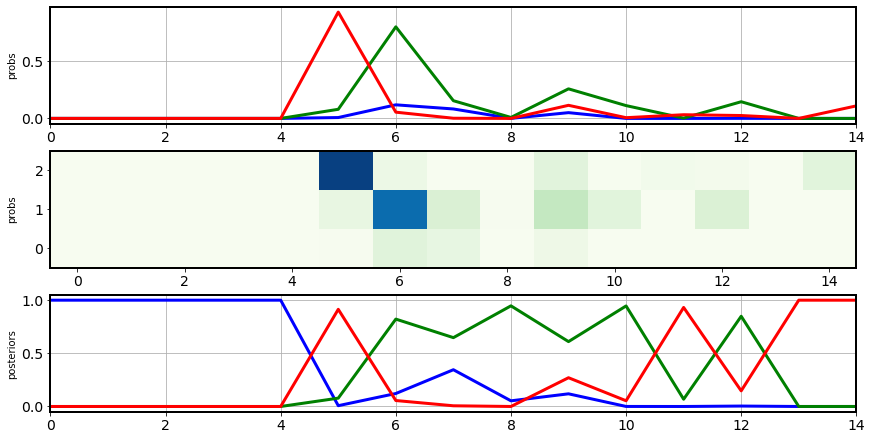

In [22]:
# the predict_prob() method computes the joint likelihood of all features
# the predict_proba() method computes the posteriors
probs=Gauss1.predict_prob(X2s)
posteriors=Gauss1.predict_proba(X2s)
fig = Spd.SpchFig(row_heights=[1.,1.,1.])
fig.add_line_plot(probs.T,iax=0,ylabel='probs')
fig.add_img_plot(probs.T,iax=1,cmap='GnBu',ylabel='probs')
fig.add_line_plot(posteriors.T,iax=2,ylabel='posteriors')
display(fig)

In [23]:
print("Accuracy on X1: %.1f%% " % (100.0*Gauss1.score(X1,y1)) )
print("Accuracy on X2: %.1f%% " % (100.0*Gauss1.score(X2,y2)) )
print("Accuracy on X3: %.1f%% " % (100.0*Gauss1.score(X3,y2)) )
print("Accuracy on X4: %.1f%% " % (100.0*Gauss1.score(X4,y2)) )

Accuracy on X1: 76.0% 
Accuracy on X2: 80.0% 
Accuracy on X3: 66.7% 
Accuracy on X4: 56.0% 


### Training the Gaussian Models

As we are given alignments, we may choose just to train the observation model, i.e. the Gaussian densities in our case.  We apply a large variance smoothing for training from such small data set to avoid overtraining as otherwise variance could be unrealistically low.

Comparing with our intuitive model 'Gauss1' we see moderate shifts of means and changes to the variances

Gaussian(var_smoothing=0.1)

,prior,mean,var
0,0.333,"[5.001436336367558, 3.468014181204941, 1.46756...","[0.46241919797706954, 0.42283860789720423, 0.3..."
1,0.333,"[5.968464557107913, 2.7995225280001796, 4.3251...","[0.6050614318509199, 0.43445625468794, 0.58450..."
2,0.333,"[6.508953840550351, 2.9342272347079636, 5.5671...","[0.6513715376967661, 0.3975231769147545, 0.580..."


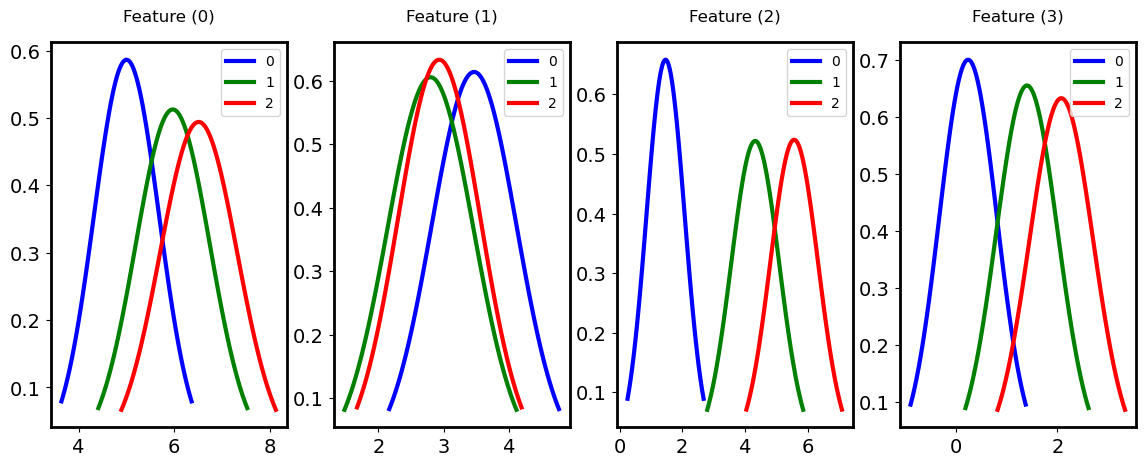

In [25]:
pd.set_option('display.precision',1)
Gauss2 = Densities.Gaussian(var_smoothing=.1)
Gauss2.fit(X1, y1)
Gauss2.print_model()
Gauss2.plot_model()

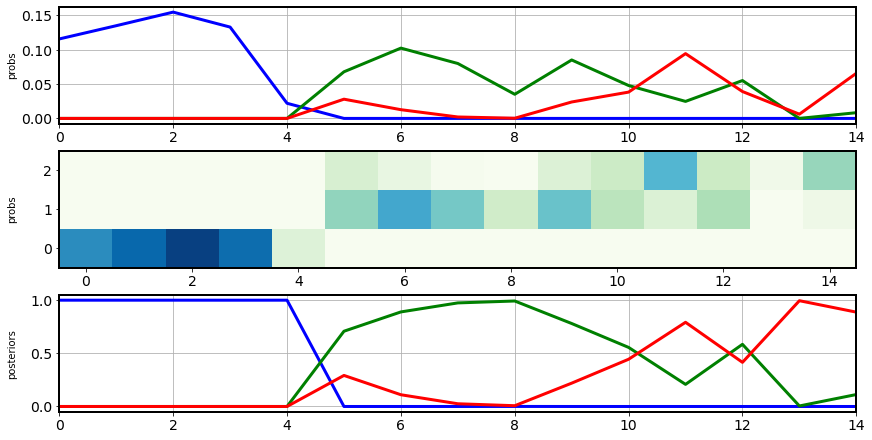

In [26]:
probs=Gauss2.predict_prob(X2s)
posteriors=Gauss2.predict_proba(X2s)
fig = Spd.SpchFig(row_heights=[1.,1.,1.])
fig.add_line_plot(probs.T,iax=0,ylabel='probs')
fig.add_img_plot(probs.T,iax=1,cmap='GnBu',ylabel='probs')
fig.add_line_plot(posteriors.T,iax=2,ylabel='posteriors')
display(fig)

### Frame classification with the trained models

We observe that the 'clean' test data scores almost as good as the training data 
indicating that we seem to have a properly trained model.   
However for the noise test data the frame error rate is still quite high.  For the 'very noisy' data we are even stuck at an error rate around 50%. 

In [27]:
print("Accuracy on X1: %.1f%% " % (100.0*Gauss2.score(X1,y1)) )
print("Accuracy on X2: %.1f%% " % (100.0*Gauss2.score(X2,y2)) )
print("Accuracy on X3: %.1f%% " % (100.0*Gauss2.score(X3,y2)) )
print("Accuracy on X4: %.1f%% " % (100.0*Gauss1.score(X4,y2)) )

Accuracy on X1: 90.7% 
Accuracy on X2: 92.0% 
Accuracy on X3: 73.3% 
Accuracy on X4: 56.0% 


### HMM with a Gaussian Observation Model

The frame classifiers above did not make use of the inherent sequence property of our data. We will now exploit the fact that we expect the data to be drawn in sequence from states 0-1-2.  Though we will not enforce this 100% as occasionally there are random switches between states.   

We make two hmm-models with the same init and transition probabilities.  
The model has a tendency left-to-right, though a very small probability allows for breaking this topology
- hmm1 : uses Gauss1 (intuitive) as observation model
- hmm2 : uses Gauss2 (trained) as observation model

We use log-prob's throughout to accomodate for small probs and long sequences

In [28]:
eps = 1.e-5
imat = np.array([1.0, eps,eps])
tmat = np.array([[.8,.2,eps],[eps,.8,.2],[eps,eps,1.]])

#hmm1 = libhmm.HMM(prob_style="lin",obs_model=Gauss1,transmat=tmat,initmat=imat)
hmm1 = libhmm.HMM(prob_style="log",obs_model=Gauss1,n_states=3,
                  transmat=np.log(tmat),initmat=np.log(imat))
hmm1.print_model()
# clone hmm1 and modify the observation model
hmm2 = copy.deepcopy(hmm1)
hmm2.obs_model = Gauss2


HMM STATE MODEL



,0,1,2
Pinit(.),0.000,-11.513,-11.513


,0,1,2
P(0|.),-0.223,-11.513,-11.513
P(1|.),-1.609,-0.223,-11.513
P(2|.),-11.513,-1.609,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.333,"[5.5, 3.5, 4.0, 1.4]","[0.1, 0.1, 0.1, 0.1]"
1,0.333,"[6.0, 2.5, 4.4, 1.5]","[0.1, 0.1, 0.1, 0.1]"
2,0.333,"[6.5, 3.0, 4.5, 2.0]","[0.1, 0.1, 0.1, 0.1]"


## Trellis Computatitons

In the next cell
- Select model  hmm1 or hmm2
- Select Datastream and reference alignment  (X1,X2,X3,X4 or X2s,X3s,X4s)
- Compute the Viterbi Trellis (Normalize=True: max value =1.0 for prob or 0.0 for logprob)

In [29]:
X = X4s
y = y2s
hmm = hmm2

In [30]:
tr = libhmm.Trellis(hmm,Normalize=True)
tr.viterbi_pass(X)
tr.print_trellis(what=['obs_probs','probs'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-22.786,-28.730,-9.739,-6.570,-58.037,-31.041,-30.832,-27.502,-49.060,-10.094,-18.401,-64.554,-44.664,-78.953,-35.482
1,-40.665,-20.559,-3.412,-16.574,-57.758,-22.470,-13.951,-19.951,-18.839,-16.562,-10.085,-27.408,-32.455,-22.858,-17.791
2,-57.538,-29.809,-8.458,-26.176,-69.626,-30.182,-17.689,-21.705,-13.325,-26.418,-16.248,-23.213,-41.986,-14.389,-15.846



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000,-6.785,-13.111,-1.286,-1.565,-10.136,-27.017,-18.840,-45.638,-0.694,-9.010,-48.965,-20.690,-74.468,-31.149
1,-29.392,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-4.128,0.000,0.000,-2.809,0.000,-7.083,-9.250
2,-46.266,-19.154,-6.432,-10.988,-13.255,-9.098,-5.125,-3.141,0.000,-5.505,-7.549,0.000,-6.498,0.000,0.000


Then, 
1. evaluate the strength of the acoustic model by itself by performing frame recognition
2. evaluate for a given setup the resulting alignment and number of errors vs. frame classificaiton
3. observe dependency on
    + quality of the model (moderate quality given model vs. properly training model)
    + performance difference train/test
    + performance difference clean/noisy data

In [31]:
## evaluate on frame based recognition
print('\nFrame Recognition vs. Viterbi Alignment vs. Reference\n')
y_frame = hmm.obs_model.predict(X)
y_viterbi = tr.backtrace()
pd.DataFrame(np.array([y_frame,y_viterbi,y]),index=['FRAME','VITERBI','REF'])
print("\nFrame Recognition Accuracy: %.1f%%" % (100.0*hmm.obs_model.score(X,y)) )
print("Viterbi Alignment Accuracy: %.1f%% "% (100.0*np.sum(y_viterbi == y)/len(y)) )
#print("\nSequence Probability: %.2f\n" % tr.seq_prob)


Frame Recognition vs. Viterbi Alignment vs. Reference



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FRAME,0,1,1,0,1,1,1,1,2,0,1,2,1,2,2
VITERBI,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2
REF,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2



Frame Recognition Accuracy: 53.3%
Viterbi Alignment Accuracy: 53.3% 


In [32]:
y_frame, y_viterbi

(array([0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]))

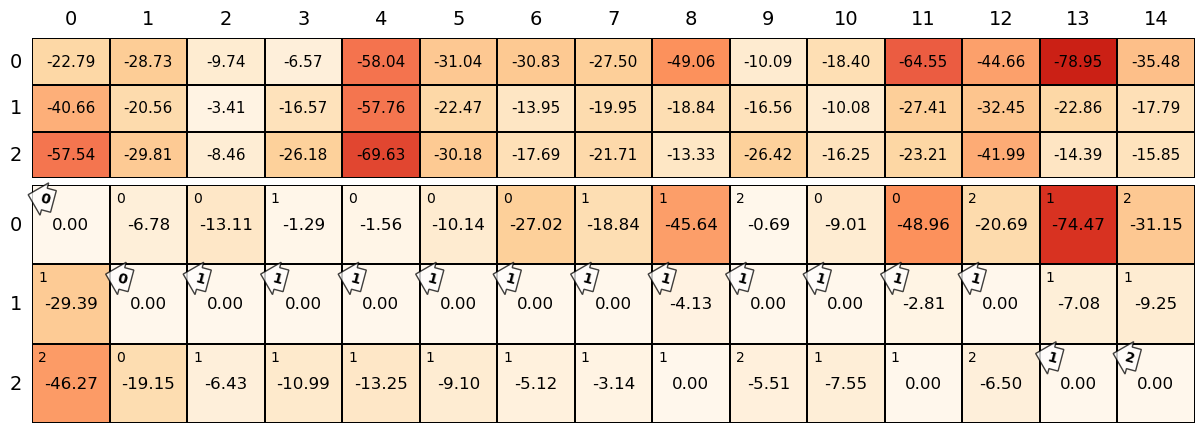

In [33]:
# column by column normalization is applied in the trellis, so the max-value shown in always 0.0 with logprobs
# hence, the sequence probability is the product of the column-scaling (or sum of log-scalings) 
cmap="OrRd_r"
tr.plot_trellis(cmap=cmap,plot_norm=True,plot_obs_probs=True,plot_values=True,fmt=".2f",vmin=-100,vmax=0,
                 plot_backptrs=True,plot_alignment=True,figsize=(15,5))